## Discrete Choice Models

In [1]:
import arviz as az
import numpy as np  # For vectorized math operations
import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt

In [2]:
wide_heating_df = pd.read_csv("../data/heating_data_r.csv")
wide_heating_df[wide_heating_df["idcase"] == 1]

,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,oc.ec,oc.er,oc.hp,income,agehed,rooms,region
0,1,gc,866.0,962.64,859.9,995.76,1135.5,199.69,151.72,553.34,505.6,237.88,7,25,6,ncostl


In [3]:
long_heating_df = pd.read_csv("../data/long_heating_data.csv")
long_heating_df[long_heating_df["idcase"] == 1]

,Unnamed: 0,idcase,alt_id,choice,depvar,income,agehed,rooms,region,installation_costs,operating_costs
0,0,1,1,1,gc,7,25,6,ncostl,866.00,199.69
1,1,1,2,0,gc,7,25,6,ncostl,962.64,151.72
2,2,1,3,0,gc,7,25,6,ncostl,859.90,553.34
3,3,1,4,0,gc,7,25,6,ncostl,995.76,505.60
4,4,1,5,0,gc,7,25,6,ncostl,1135.50,237.88


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/special.py:491: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Sampling: [beta_ic, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.034160
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.435059
Transforming variables...
Transformation time =  0:00:00.415694
Computing Log Likelihood...


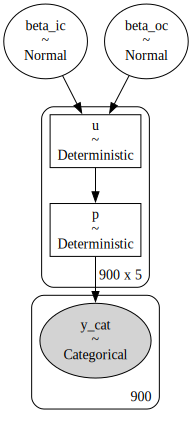

In [4]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes
# observed = pd.get_dummies(wide_heating_df['depvar'])
# observed = long_heating_df['choice']


with pm.Model() as model:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)

    u0 = beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # pivot
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    p_ = pm.Deterministic("p", pt.special.softmax(s))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed)
    # choice_obs = pm.Multinomial('y_cat', n=1, p=p_, observed=observed)

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=101)
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model)

In [5]:
az.summary(idata_m1, var_names=["beta_ic", "beta_oc"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.002,0.0,0.002,0.002,0.0,0.0,1870.0,1999.0,1.0
beta_oc,-0.004,0.0,-0.005,-0.004,0.0,0.0,881.0,1105.0,1.0


array([[<Axes: title={'center': 'beta_ic'}>,
        <Axes: title={'center': 'beta_ic'}>],
       [<Axes: title={'center': 'beta_oc'}>,
        <Axes: title={'center': 'beta_oc'}>]], dtype=object)

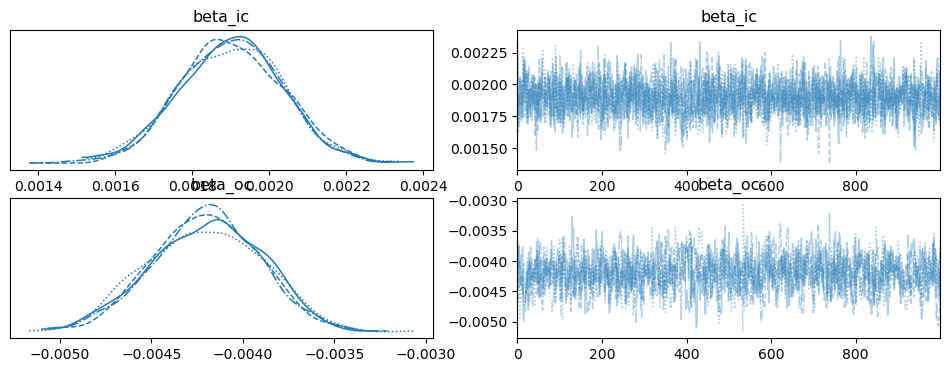

In [6]:
az.plot_trace(idata_m1, var_names=["beta_ic", "beta_oc"])

<Axes: xlabel='y_cat / y_cat'>

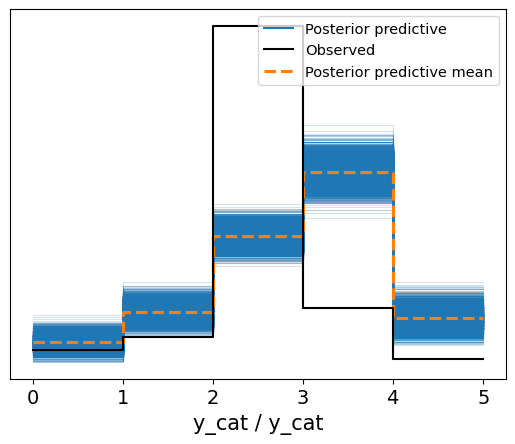

In [7]:
az.plot_ppc(idata_m1)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/special.py:491: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Sampling: [alpha, beta_ic, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.353455
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:12.684179
Transforming variables...
Transformation time =  0:00:00.284736
Computing Log Likelihood...


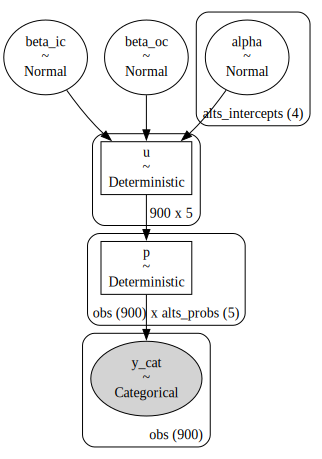

In [8]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes
# observed = pd.get_dummies(wide_heating_df['depvar'])
# observed = long_heating_df['choice']

coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")

    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # pivot
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    p_ = pm.Deterministic("p", pt.special.softmax(s), dims=("obs", "alts_probs"))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")
    # choice_obs = pm.Multinomial('y_cat', n=1, p=p_, observed=observed)

    idata_m2 = pm.sample_prior_predictive()
    idata_m2.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m2.extend(pm.sample_posterior_predictive(idata_m2))


pm.model_to_graphviz(model)

In [9]:
az.summary(idata_m2, var_names=["beta_ic", "beta_oc", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.001,0.000,-0.000,0.001,0.000,0.000,1215.0,1612.0,1.00
beta_oc,-0.003,0.001,-0.005,-0.001,0.000,0.000,1379.0,1743.0,1.00
alpha[ec],1.039,0.497,0.076,1.936,0.016,0.012,908.0,1054.0,1.00
alpha[er],1.077,0.474,0.216,1.988,0.016,0.012,839.0,991.0,1.00
alpha[gc],2.376,0.309,1.789,2.953,0.011,0.008,814.0,836.0,1.01
alpha[gr],0.733,0.373,-0.031,1.374,0.013,0.009,854.0,947.0,1.01


In [10]:
-0.003 / 0.001

-3.0

<Axes: xlabel='y_cat / y_cat'>

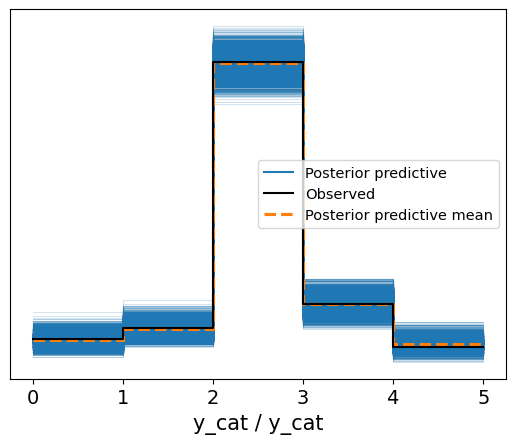

In [11]:
az.plot_ppc(idata_m2)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/special.py:491: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Sampling: [alpha, beta_ic, beta_income, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.093440
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:21.441632
Transforming variables...
Transformation time =  0:00:00.283570
Computing Log Likelihood...


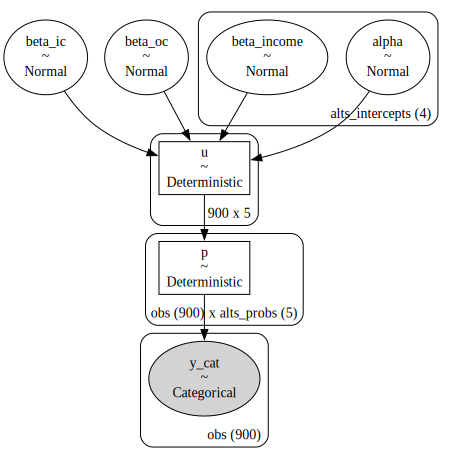

In [12]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")

    u0 = (
        alphas[0]
        + beta_ic * wide_heating_df["ic.ec"]
        + beta_oc * wide_heating_df["oc.ec"]
        + beta_income[0] * wide_heating_df["income"]
    )
    u1 = (
        alphas[1]
        + beta_ic * wide_heating_df["ic.er"]
        + beta_oc * wide_heating_df["oc.er"]
        + beta_income[1] * wide_heating_df["income"]
    )
    u2 = (
        alphas[2]
        + beta_ic * wide_heating_df["ic.gc"]
        + beta_oc * wide_heating_df["oc.gc"]
        + beta_income[2] * wide_heating_df["income"]
    )
    u3 = (
        alphas[3]
        + beta_ic * wide_heating_df["ic.gr"]
        + beta_oc * wide_heating_df["oc.gr"]
        + beta_income[3] * wide_heating_df["income"]
    )
    u4 = np.zeros(N)  # pivot
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    p_ = pm.Deterministic("p", pt.special.softmax(s), dims=("obs", "alts_probs"))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")
    # choice_obs = pm.Multinomial('y_cat', n=1, p=p_, observed=observed)

    idata_m3 = pm.sample_prior_predictive()
    idata_m3.extend(pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}))
    idata_m3.extend(pm.sample_posterior_predictive(idata_m3))


pm.model_to_graphviz(model)

<Axes: xlabel='y_cat / y_cat'>

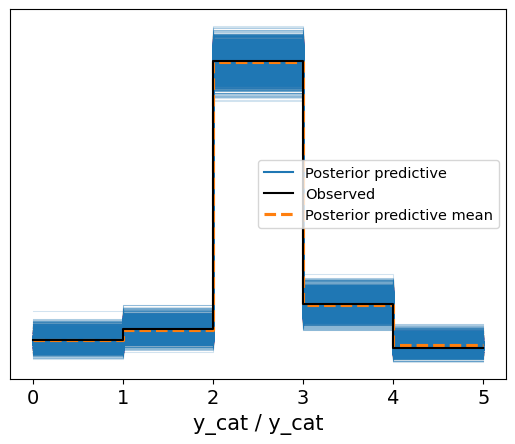

In [13]:
az.plot_ppc(idata_m3)

In [14]:
az.summary(idata_m3, var_names=["beta_income", "beta_ic", "beta_oc", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_income[ec],0.114,0.102,-0.083,0.296,0.003,0.002,1355.0,2157.0,1.0
beta_income[er],0.080,0.098,-0.094,0.270,0.003,0.002,1255.0,2103.0,1.0
beta_income[gc],0.088,0.078,-0.053,0.237,0.002,0.002,1092.0,1636.0,1.0
beta_income[gr],-0.018,0.089,-0.186,0.147,0.003,0.002,1147.0,1704.0,1.0
beta_ic,0.001,0.001,-0.000,0.002,0.000,0.000,2624.0,2712.0,1.0
beta_oc,-0.003,0.001,-0.006,-0.001,0.000,0.000,3188.0,3039.0,1.0
alpha[ec],0.795,0.583,-0.266,1.875,0.015,0.010,1572.0,2070.0,1.0
alpha[er],0.988,0.552,-0.046,2.000,0.014,0.010,1477.0,2042.0,1.0
alpha[gc],2.130,0.394,1.407,2.885,0.011,0.008,1193.0,1953.0,1.0
alpha[gr],0.970,0.466,0.100,1.853,0.013,0.009,1329.0,1874.0,1.0


In [15]:
az.compare({"m1": idata_m1, "m2": idata_m2, "m3": idata_m3}, "loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m2,0,-1023.600913,4.964848,0.000000,0.995913,27.802378,0.00000,False,log
m3,1,-1025.963929,9.033405,2.363016,0.004087,28.059227,2.19694,False,log
m1,2,-1309.610756,1.196740,286.009843,0.000000,12.933018,22.67761,False,log


In [16]:
idata_m3

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [17]:
az.extract(idata_m3, var_names=["p"]).mean(axis=2).mean(axis=0)

<xarray.DataArray 'p' (alts_probs: 5)>
array([0.07028404, 0.09218208, 0.63429286, 0.1425662 , 0.06067482])
Coordinates:
  * alts_probs  (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp'